In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.portfolio_management.portfolio import Portfolio, OptimizedPortfolio
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

In [6]:
orivault.connect()
a = orivault.retrieve("results")
orivault.disconnect()

In [7]:
valid = a[(a["position_type"]=="long") & (a["selection_type"]!="long_short")].sort_values("sharpe_ratio",ascending=False).head(20)
valid.head(5)

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,rolling_window
42,ema_volume_corr,MONTH,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,2024-12-31,217.773947,5.022106,43.363073,1.137728,0.867787,0.741667,1.067993,4.888954,20
18,ema_volume_corr,QUARTER,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,2024-12-31,26.764373,5.421735,4.936496,1.404200,0.795781,0.625000,1.176043,4.371808,20
16,ema_volume_corr,QUARTER,long,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2024-12-31,24.922757,4.411897,5.648989,1.329364,0.737175,0.650000,1.122098,3.494395,20
40,ema_volume_corr,MONTH,long,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2024-12-31,14.134327,4.412365,3.203345,1.097237,0.854004,0.716667,1.028321,2.609911,20
8,ema_volume_corr,QUARTER,long,OFFICE,mixed,equal,coefficient_of_variation,0.5,2024-12-31,3.689298,3.898602,0.946313,1.177284,0.835532,0.578409,1.033204,-1.578401,20


In [8]:
top = valid.head().to_dict("records")[0]
top

{'ranking_metric': 'ema_volume_corr',
 'timeframe': 'MONTH',
 'position_type': 'long',
 'grouping_type': 'ASSET_CLASS',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-31 00:00:00'),
 'pnl': 217.7739471383792,
 'coefficient_of_variation': 5.022105991301826,
 'portfolio_std': 43.36307268615174,
 'average_gain': 1.1377280146653939,
 'average_loss': 0.8677871712656422,
 'win_loss_ratio': 0.7416666666666667,
 'weekly_return': 1.0679932967871246,
 'sharpe_ratio': 4.888953920125023,
 'rolling_window': 20}

In [9]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            price = Indicator.EMAVolumeCorr.calculate(price,timeframe=top["rolling_window"])
            for member in RiskType:
                price = member.apply(price)	
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4006/4006 [03:15<00:00, 20.52it/s]


In [10]:
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["market_cap"] = simulation["market_cap"].astype(float)
simulation["asset_class"] = "common_stock"
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())

simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low',
       'ema_volume_corr', 'coefficient_of_variation', 'name', 'market_cap',
       'office', 'sic_description', 'asset_class'],
      dtype='object')

In [11]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [12]:
base_portfolio = Portfolio.from_dict(top)

In [13]:
portfolios = PortfolioSelection.optimize_portfolio(base_portfolio,group_percentages=[0.001,.0065,.01])

In [14]:
analysises = []
for portfolio in tqdm(portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = Metrics.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:37<00:00, 10.88s/it]


In [15]:
a = pd.DataFrame(analysises)
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
0,0,ema_volume_corr,MONTH,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.0010,887.626219,4.565224,194.432133,1.166678,0.874921,0.725000,1.086445,4.535528,<financial_common.portfolio_management.portfol...
1,1,ema_volume_corr,MONTH,long,ASSET_CLASS,top,market_cap,coefficient_of_variation,0.0010,887.626219,4.565224,194.432133,1.166678,0.874921,0.725000,1.086445,4.535528,<financial_common.portfolio_management.portfol...
2,2,ema_volume_corr,MONTH,long,ASSET_CLASS,top,risk,coefficient_of_variation,0.0010,576.534363,4.466850,129.069574,1.181226,0.877061,0.625000,1.067164,4.422115,<financial_common.portfolio_management.portfol...
3,3,ema_volume_corr,MONTH,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.0065,1.055513,8.752431,0.120597,1.077853,0.919655,0.541810,1.005368,-39.125226,<financial_common.portfolio_management.portfol...
6,6,ema_volume_corr,MONTH,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.0100,0.927997,7.581345,0.122405,1.074766,0.921065,0.539227,1.003945,-39.588837,<financial_common.portfolio_management.portfol...
4,4,ema_volume_corr,MONTH,long,ASSET_CLASS,top,market_cap,coefficient_of_variation,0.0065,0.701404,4.930165,0.142268,1.004356,0.996868,0.518966,1.000754,-35.654410,<financial_common.portfolio_management.portfol...
7,7,ema_volume_corr,MONTH,long,ASSET_CLASS,top,market_cap,coefficient_of_variation,0.0100,0.693349,4.953984,0.139958,1.002939,0.997930,0.511417,1.000492,-36.300473,<financial_common.portfolio_management.portfol...
8,8,ema_volume_corr,MONTH,long,ASSET_CLASS,top,risk,coefficient_of_variation,0.0100,0.631196,4.018882,0.157057,1.003035,0.996071,0.538642,0.999822,-32.743979,<financial_common.portfolio_management.portfol...
5,5,ema_volume_corr,MONTH,long,ASSET_CLASS,top,risk,coefficient_of_variation,0.0065,0.619250,3.706403,0.167076,1.004707,0.994084,0.540948,0.999830,-30.852066,<financial_common.portfolio_management.portfol...


In [16]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

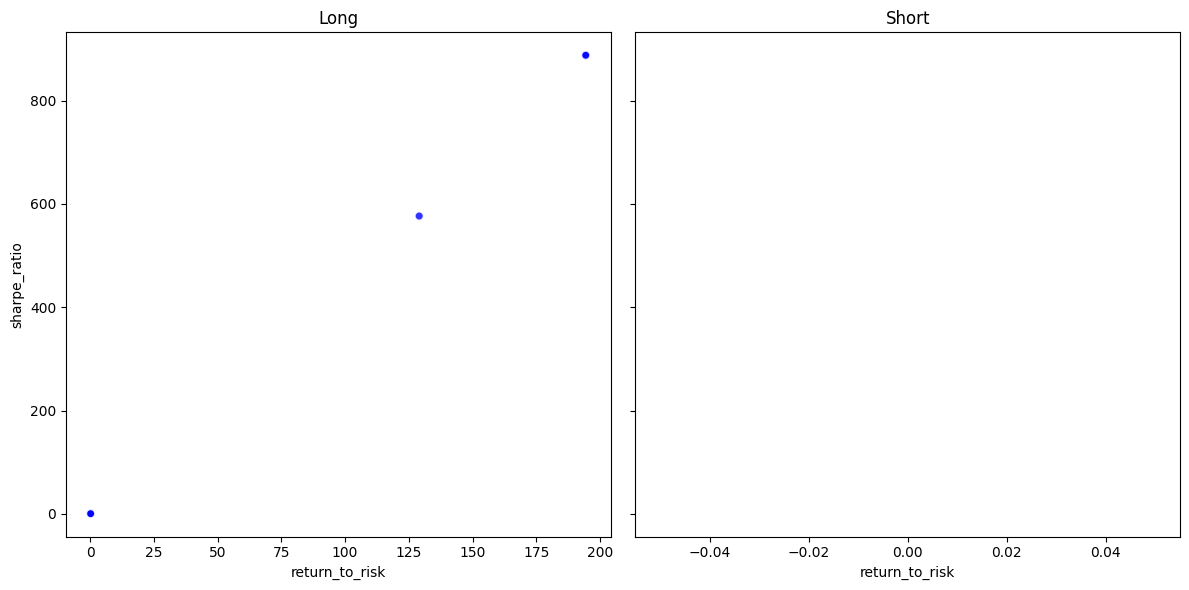

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [18]:
top = a.sort_values("pnl",ascending=False).iloc[0].to_dict()
top

{'ranking_metric': 'ema_volume_corr',
 'timeframe': 'MONTH',
 'position_type': 'long',
 'grouping_type': 'ASSET_CLASS',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.001,
 'date': Timestamp('2024-12-31 00:00:00+0000', tz='UTC'),
 'pnl': 887.6262190949707,
 'coefficient_of_variation': 4.56522389901196,
 'portfolio_std': 194.43213273440486,
 'average_gain': 1.1666784839911226,
 'average_loss': 0.8749214779149096,
 'win_loss_ratio': 0.725,
 'weekly_return': 1.086445307320164,
 'sharpe_ratio': 4.535527763607024,
 'portfolio': <financial_common.portfolio_management.portfolio.OptimizedPortfolio at 0x28043148d10>,
 'color': 'blue',
 'return_to_risk': 4.56522389901196}

In [19]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

In [20]:
portfolio.sort_values("return",ascending=False).head(20)

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week
0,2015-01-30 00:00:00+00:00,1.909091,1.909091,41.301901,1.000000,2015,1,1,5
9,2015-10-30 00:00:00+00:00,1.909091,12.621245,49.799085,1.205733,2015,10,4,44
23,2016-12-30 00:00:00+00:00,1.909091,24.462953,68.869408,1.667463,2016,12,4,52
30,2017-07-31 00:00:00+00:00,1.909091,29.824683,74.493000,1.803622,2017,7,3,31
44,2018-09-28 00:00:00+00:00,1.909091,61.268834,93.533075,2.264619,2018,9,3,39
84,2022-01-31 00:00:00+00:00,1.909091,167.233326,136.716026,3.310163,2022,1,1,5
72,2021-01-29 00:00:00+00:00,1.909091,43.866401,115.619773,2.799381,2021,1,1,4
77,2021-06-30 00:00:00+00:00,1.769039,94.238058,140.583336,3.403798,2021,6,2,26
112,2024-05-31 00:00:00+00:00,1.743750,699.666053,199.278784,4.824930,2024,5,2,22
8,2015-09-30 00:00:00+00:00,1.680000,6.611128,46.917335,1.135961,2015,9,3,40


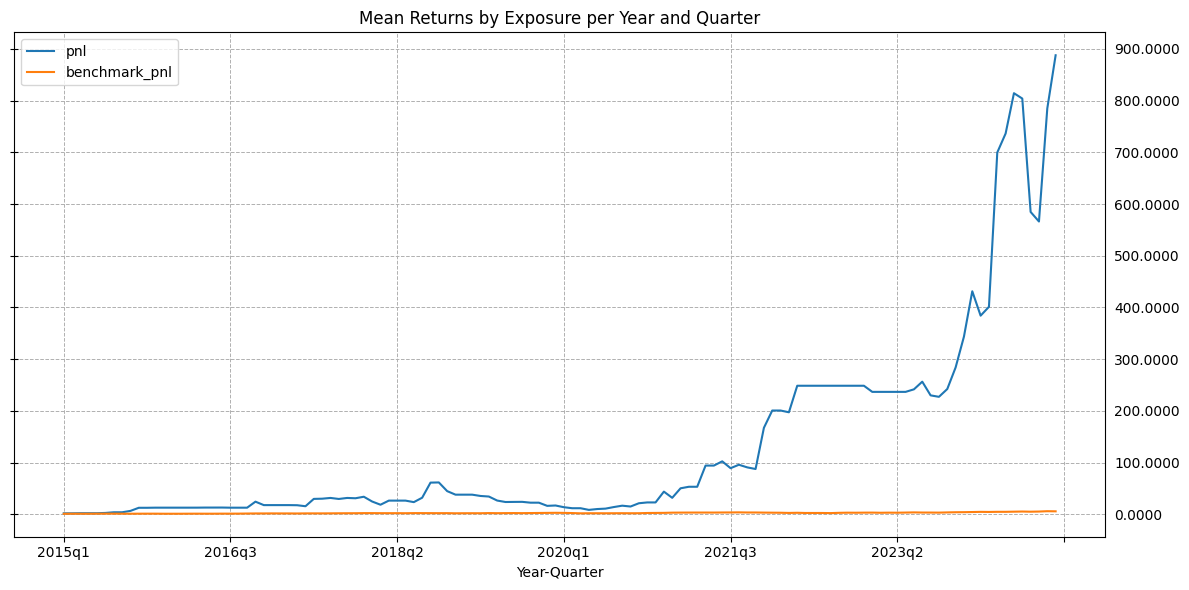

In [21]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [22]:
trades.sort_values(["date","weight"],ascending=False).dropna().head(50)

,year,month,ticker,date,adjclose,sell_price,asset_class,ema_volume_corr,coefficient_of_variation,risk,...,selection,position_type,weight,unweighted_return,winsorized_return,return,name,market_cap,quarter,week
89,2024,12,TSLA,2024-12-31 00:00:00+00:00,357.090000,403.840000,common_stock,1.467642e+09,0.176179,0.176179,...,True,1.0,1,1.130919,1.130919,1.130919,"Tesla, Inc. Common Stock",9.004859e+11,4,1
99,2024,11,TSLA,2024-11-29 00:00:00+00:00,248.980000,345.160000,common_stock,5.903173e+08,0.104732,0.104732,...,True,1.0,1,1.386296,1.386296,1.386296,"Tesla, Inc. Common Stock",9.004859e+11,4,48
87,2024,10,TSLA,2024-10-31 00:00:00+00:00,258.020000,249.850000,common_stock,1.506340e+09,0.135722,0.135722,...,True,1.0,1,0.968336,0.968336,0.968336,"Tesla, Inc. Common Stock",9.004859e+11,4,44
16,2024,9,CAPS,2024-09-30 00:00:00+00:00,4.500000,3.250000,common_stock,inf,0.092085,0.092085,...,True,1.0,1,0.727273,0.727273,0.727273,Capstone Holding Corp. Common Stock,1.043240e+07,3,40
110,2024,8,TSLA,2024-08-30 00:00:00+00:00,216.860000,214.110000,common_stock,1.896814e+08,0.158244,0.158244,...,True,1.0,1,0.987319,0.987319,0.987319,"Tesla, Inc. Common Stock",9.004859e+11,3,35
96,2024,7,TSLA,2024-07-31 00:00:00+00:00,209.860000,232.070000,common_stock,8.850891e+08,0.070793,0.070793,...,True,1.0,1,1.105832,1.105832,1.105832,"Tesla, Inc. Common Stock",9.004859e+11,3,31
74,2024,6,MAYS,2024-06-28 00:00:00+00:00,43.510000,45.790000,common_stock,inf,0.020120,0.020120,...,True,1.0,1,1.052402,1.052402,1.052402,Mays (J.W.) Inc,8.214304e+07,2,26
7,2024,5,EXOD,2024-05-31 00:00:00+00:00,8.000000,13.950000,common_stock,inf,0.447497,0.447497,...,True,1.0,1,1.743750,1.743750,1.743750,"Exodus Movement, Inc.",1.301237e+09,2,22
47,2024,4,AMOD,2024-04-30 00:00:00+00:00,10.770000,11.250000,common_stock,inf,0.005544,0.005544,...,True,1.0,1,1.044568,1.044568,1.044568,"Alpha Modus Holdings, Inc. Class A Common Stock",1.621981e+07,2,18
94,2024,3,AMD,2024-03-28 00:00:00+00:00,202.640000,180.490000,common_stock,9.051125e+08,0.201820,0.201820,...,True,1.0,1,0.890693,0.890693,0.890693,Advanced Micro Devices,1.570127e+11,1,13
